# Quantifying Growth Rate Between Tube and Plate Growth Conditions

In [102]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy
import mwc_induction_utils_processing as mwc

# For statistics
import scipy.optimize
import numdifftools as ndt

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## What is this?

The purpose of this notebook is to quanitfy the growth rates of our HG105 25-O2+11-YFP::*galK* (delta) strain when grown in tubes versus being grown in 2mL 96-well plates. The motivation for this control experiment is to verify that the results between our current work and that of [Garcia and Phillips, PNAS 2011]() are directly comparable. The procedure for this experiment is given below. 

## Protocol

1. A 2mL aliquot of LB + Kanamycin (30µg/mL) + Spectinomycin (100µg/mL) was inoculated with a small scrape from an -80°C frozen glycerol stock of HG105 25-O2+11-YFP::*galK* + pZS3\*1-mCherry and was allowed to grow at 37°C while shaking at 250rpm for approximately 9 hours. This culture was grown in a loosely sealed 14mL conical tube. 

2. At 08h30m, 500µL of the overnight saturated culture was transferred to a freshly prepared and warmed (37°C) 500mL aliquot of M9 + 0.5% glucose with no antibiotic. This diluted culture was thoroughly mixed by hand. 

3. Aliquots of 4mL were transferred individually into 96 sterile 14mL falcon tubes in front of an open flame. 

4. Once all tubes were properly inoculated, a 500µL aliquot of the cell suspension was transferred into each well of a 2mL deep-well 96 well plate. This plate was sealed with a breatheable Rayon fabric cover. 

5. At 08h45m, the 3.5 racks of tubes as well as the 96 well plate were transferred to the 37°C incubation room and were affixed to the upper right-hand corner of the shaker. At this point, a timer was started. 

6. At regular time intervals, the OD~600nm~ of three cultures was measured using a handheld spectrophotometer and recorded on a communal lab notebook. To measure the tube OD~600nm~ absorbance, three tubes were selected from the racks. An aliquot of 500µL was removed from a tube and placed into a 1cm path length UV transparent cuvette. The OD was measured and recorded. Both the tube and the cuvette containing the culture were discarded. For measuring the OD of the plate-grown samples, the Rayon breatheable cover was perforated using a 1250µL pipette tip and the entire culture was withdrawn. This approximately 500µL aliquot was removed and transerred to a cuvette as described above. 

The data was recorded in a benchling lab notebook and the [data was stored as a csv file](../../data/20160816_growth_measurements.csv) and contain the time that each measurement was performed, the total time of growth up to that measurement, and who measured each time point. Let's take a look at the data. 

In [103]:
# Load up the growth curve data. 
data = pd.read_csv('../../data/20160816_growth_measurements.csv')


We can start simply by plotting the data and exploring its behavior.

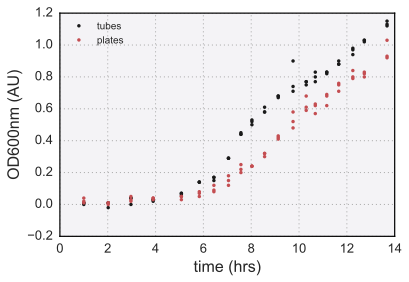

In [104]:
# Group the data for ease of use.
grouped_data = data.groupby('sample')
tubes = grouped_data.get_group('tube')
plates = grouped_data.get_group('plate')

# Plot the OD values as a function of time. 
plt.plot(tubes.time, tubes.od_600nm, '.', color='k', label='tubes')
plt.plot(plates.time, plates.od_600nm, '.', color='r', label='plates')
plt.xlabel('time (hrs)')
plt.ylabel('OD600nm (AU)')
plt.legend(loc='upper left')


It is fair to say that our *E. coli* cells likely grow exponentially. Given all of this data, let's do a simple nonlinear regression on to identify the growth rate. As a reminder, we can define the growth rate as

\begin{equation}
N(t) = N_0 \exp{kt}
\end{equation}

In [108]:
# Define the residual fnction.
def resid(k, p):
    t, n_t = p
    return n_t - np.exp(k * t)


# Define the log posterior.
def log_post(k, p):
    """
    Returns the log of the posterior. 
    
    Parameters
    ----------
    k : float
        Growth constant
    """
    t, n_t = p
    return -len(n_t) / 2 * np.log(np.sum(n_t - np.exp(k * t))**2)

In [111]:
# Generate an initial guess for the growth rate. 
p0 = 1.0

tubes = tubes[(tubes.time > 6) & (tubes.time < 12)]
plates = plates[(plates.time > 6) & (plates.time < 12)]
# Define the arguments to feed our minimization function. 
args_tubes = [tubes.time, tubes.od_600nm]
args_plates = [plates.time, plates.od_600nm]


# Minimize it!
tubes_popt, _ = scipy.optimize.leastsq(resid, p0, args_tubes)
plates_popt, _ = scipy.optimize.leastsq(resid, p0, args_plates)

# Now we can extract the optimized values.
k_tubes = tubes_popt[0]
k_plates = plates_popt[0]

# Instantiate the hessian. 
hes_fun = ndt.Hessian(log_post)
hes_tubes = hes_fun(k_tubes, (tubes.time, tubes.od_600nm))
hes_plates = hes_fun(k_plates, (plates.time, plates.od_600nm))
cov_tubes = -np.linalg.inv(hes_tubes)
cov_plates = -np.linalg.inv(hes_plates)

# Now let's print out our most probable values and our uncertainty. 
print("""
Most Probable Values for k (≈ 68% of total probability)
-------------------------------------------------------
Tube Growth  = {0:0.1f} ± {1:0.1f} hr^-1
Plate Growth = {2:0.1f} ± {3:0.1f} hr^-1


""".format(k_tubes , np.sqrt(cov_tubes[0,0]), k_plates, np.sqrt(cov_plates[0,0])))



Most Probable Values for k (≈ 68% of total probability)
-------------------------------------------------------
Tube Growth  = -0.0 ± 0.1 hr^-1
Plate Growth = -0.1 ± 0.1 hr^-1





In [10]:


pd.read_csv?
#Date: 2016-08-16
#Experiment: Growth curve measurement and comparison between plate and tube
#growth.
#Comments:
#A 2mL LB culture with added spectinomycin (100µg/mL) and kanamycin (30µg/mL)
#was inoculated with a scrape of a frozen HG105 25-O2+11-YFP::galK Kan::ybcN
#pZS3*1-mCherry E. coli stock. This culture was grown for approximately 9
#hours and was completely saturated. 
#A 1:1000 dilution into 500mL of prewarmed 500mL of M9 + 0.5% glucose was
#performed and the solution was throughouly mixed. Aliquots of 4mL were placed
#individually using the large-tip pipette into 96 individual 14mL Falcon tubes.
#The remainder of the diluted cell suspension was poured into a plastic boat.
#Aliquots of 500µL were transferred into a sterilized 2mL 96-well plate and was
#sealed with a breatheable Rayon cover.  The tubes and the plate were placed in
#the approximately same position in the upper right-hand corner of the shaker
#located in the 37°C incubation room at 08h45m. The cultures were allowed to
#shake at approximately 250rpm and the OD600nm was measured.  OD600nm
#measurements were performed in triplicate for each time point. Aliquots of
#500µL were removed from three separate tubes and measured in a 1cm path length
#UV transparent cuvette. To measure the plate grown samples, the breatheable
#Rayon cover was pierced with a 1250µL pipette tip and the entire culture was
#removed and placed into a cuvette. 
